Assignment 7

In [2]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import unicodedata
import re
import numpy as np
import os
import io
import time

In [3]:
import sys
print(sys.version)

3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]


In [4]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):

  #w = unicode_to_ascii(w.lower().strip()) # No impact on output. Do we need this ....
  
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  #print(w)
  hindialpha = ""
  for char in range(2304,2432):
    hindialpha += "\\u0" + str(hex(char)[2:])

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  #w = re.sub(r"[^a-zA-Z?.!,¿।]+" + hindialpha , " ", w)

  w = re.sub(r"[^a-zA-Z?.!,\u0900\u0901\u0902\u0903\u0904\u0905\u0906\u0907\u0908\u0909\u090a\u090b\u090c\u090d\u090e\u090f\u0910\u0911\u0912\u0913\u0914\u0915\u0916\u0917\u0918\u0919\u091a\u091b\u091c\u091d\u091e\u091f\u0920\u0921\u0922\u0923\u0924\u0925\u0926\u0927\u0928\u0929\u092a\u092b\u092c\u092d\u092e\u092f\u0930\u0931\u0932\u0933\u0934\u0935\u0936\u0937\u0938\u0939\u093a\u093b\u093c\u093d\u093e\u093f\u0940\u0941\u0942\u0943\u0944\u0945\u0946\u0947\u0948\u0949\u094a\u094b\u094c\u094d\u094e\u094f\u0950\u0951\u0952\u0953\u0954\u0955\u0956\u0957\u0958\u0959\u095a\u095b\u095c\u095d\u095e\u095f\u0960\u0961\u0962\u0963\u0964\u0965\u0966\u0967\u0968\u0969\u096a\u096b\u096c\u096d\u096e\u096f\u0970\u0971\u0972\u0973\u0974\u0975\u0976\u0977\u0978\u0979\u097a\u097b\u097c\u097d\u097e\u097f]+", " ", w)

  #w = re.sub(r"[^a-zA-Z?.|\W\d_?.!|]+"," ",w)

  #print(w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

en_sentence = u"May I borrow this book? *^%"
sp_sentence = u"¿Puedo tomar prestado este libro?"
hin_sentence = u"आपका * स्वागत है।  & %"
print("hin_sentence: ",hin_sentence)
print(preprocess_sentence(en_sentence))
# print(preprocess_sentence(sp_sentence)) # .encode('utf-8')
print(preprocess_sentence(hin_sentence)) # .encode('utf-8')

hin_sentence:  आपका * स्वागत है।  & %
<start> May I borrow this book ? <end>
<start> आपका स्वागत है। <end>


In [5]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:-1]]  for l in lines[:num_examples]]

  return zip(*word_pairs)

en, hin = create_dataset('hin.txt', None)
print(en[-1])
print(hin[-1])

<start> When I was a kid , touching bugs didn t bother me a bit . Now I can hardly stand looking at pictures of them . <end>
<start> जब मैं बच्चा था , मुझे कीड़ों को छूने से कोई परेशानी नहीं होती थी , पर अब मैं उनकी तस्वीरें देखना भी बर्दाश्त नहीं कर सकता। <end>


In [6]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  
  # Updates internal vocabulary based on a list of texts.
  # In the case where texts contains lists, we assume each entry of the lists to be a token.
  lang_tokenizer.fit_on_texts(lang)

  #print("lang_tokenizer.fit_on_texts(lang): {}".format(lang_tokenizer.fit_on_texts(lang)))  # Returns None
  

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
  
  # print("lang_tokenizer: {}".format(lang_tokenizer))
  # print("tensor: {}".format(tensor))
  return tensor, lang_tokenizer

def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  # print("targ_lang: {}".format(targ_lang))
  # print("inp_lang: {}".format(inp_lang))

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  # print("input_tensor: {}".format(input_tensor))
  # print("inp_lang_tokenizer: {}".format(inp_lang_tokenizer))
  # print("target_tensor: {}".format(target_tensor))
  # print("targ_lang_tokenizer: {}".format(targ_lang_tokenizer))
  # input()

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer


# Try experimenting with the size of that dataset
num_examples =  2923 #En30000tire Data set  #
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset("hin.txt", num_examples) # hin.txt

print("input_tensor: {}".format(input_tensor))
print("input_tensor[0]: {}".format(input_tensor[0]))
print("input_tensor shape: {}".format(input_tensor.shape))
print("target_tensor: {}".format(target_tensor))
print("target_tensor[0]: {}".format(target_tensor[0]))
print("target_tensor shape: {}".format(target_tensor.shape))
print("inp_lang: {}".format(inp_lang))
print("targ_lang: {}".format(targ_lang))

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]


# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

input_tensor: [[   1  780   74 ...    0    0    0]
 [   1 1487   74 ...    0    0    0]
 [   1 1488  781 ...    0    0    0]
 ...
 [   1 3053  778 ...    0    0    0]
 [   1  146   64 ...    0    0    0]
 [   1  143    7 ...   27  158    2]]
input_tensor[0]: [  1 780  74   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0]
input_tensor shape: (2923, 29)
target_tensor: [[   1 1282   64 ...    0    0    0]
 [   1   96   64 ...    0    0    0]
 [   1  561    3 ...    0    0    0]
 ...
 [   1 2363   10 ...    0    0    0]
 [   1   80   16 ...    0    0    0]
 [   1   67    5 ...  149    3    2]]
target_tensor[0]: [   1 1282   64    2    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
target_tensor shape: (2923, 28)
inp_lang: <keras_preprocessing.text.Tokenizer object at 0x7f59db997320>
targ_lang: <keras_preprocessing.text.Tokenizer object at 0x7f59db997780>
2338 2338 

In [7]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
idx = 1282
print(" %d ----> %s" % (idx,inp_lang.index_word[1282]))
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])
print(" %d ----> %s" % (idx,targ_lang.index_word[1282]))


index_word_dict_len = len(targ_lang.index_word)
print("index_word_dict_len: {}".format(index_word_dict_len))
targ_lang.index_word[len(targ_lang.index_word) + 1] = 'UNKNOWN'
idx = len(targ_lang.index_word)
print(" %d ----> %s" % (idx,targ_lang.index_word[idx]))
targ_lang.word_index['UNKNOWN'] = idx

print(targ_lang.index_word)

Input Language; index to word mapping
1 ----> <start>
8 ----> वह
10 ----> मुझे
106 ----> भारत
13 ----> के
134 ----> बारे
5 ----> में
2521 ----> कहानियाँ
2522 ----> सुनाया
94 ----> करता
23 ----> था।
2 ----> <end>
 1282 ----> मतलब
Target Language; index to word mapping
1 ----> <start>
11 ----> he
253 ----> used
6 ----> to
142 ----> tell
17 ----> me
1933 ----> stories
79 ----> about
86 ----> india
3 ----> .
2 ----> <end>
 1282 ----> wow
index_word_dict_len: 2367
 2368 ----> UNKNOWN
{1: '<start>', 2: '<end>', 3: '.', 4: 'the', 5: 'i', 6: 'to', 7: 'you', 8: '?', 9: 'a', 10: 'is', 11: 'he', 12: 'of', 13: 't', 14: 'in', 15: 'it', 16: 'my', 17: 'me', 18: 'have', 19: 'this', 20: 'she', 21: 'do', 22: 'that', 23: 'was', 24: ',', 25: 's', 26: 'for', 27: 'are', 28: 'what', 29: 'we', 30: 'his', 31: 'your', 32: 'don', 33: 'can', 34: 'will', 35: 'on', 36: 'at', 37: 'him', 38: 'not', 39: 'her', 40: 'go', 41: 'like', 42: 'tom', 43: 'with', 44: 'be', 45: 'm', 46: 'how', 47: 'and', 48: 'know', 49: 'has', 

In [8]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

print("vocab_inp_size: {}".format(vocab_inp_size))
print("vocab_tar_size: {}".format(vocab_tar_size))
print("input word to index mapping: {}".format(inp_lang.word_index))
print("target word to index mapping: {}".format(targ_lang.word_index))

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

print(example_input_batch)

vocab_inp_size: 3061
vocab_tar_size: 2369
input word to index mapping: {'<start>': 1, '<end>': 2, 'है।': 3, '?': 4, 'में': 5, 'नहीं': 6, 'मैं': 7, 'वह': 8, 'से': 9, 'मुझे': 10, 'क्या': 11, 'है': 12, 'के': 13, 'को': 14, 'की': 15, 'हैं।': 16, 'हो': 17, 'बहुत': 18, 'का': 19, 'एक': 20, 'उसने': 21, 'पर': 22, 'था।': 23, 'यह': 24, 'हूँ।': 25, 'तुम': 26, 'कर': 27, 'लिए': 28, 'कि': 29, 'मेरे': 30, ',': 31, 'हैं': 32, 'और': 33, 'अपने': 34, 'उसे': 35, 'भी': 36, 'इस': 37, 'ने': 38, 'टॉम': 39, 'मेरी': 40, 'मैंने': 41, 'रहा': 42, 'करने': 43, 'पास': 44, 'तो': 45, 'हम': 46, 'अपनी': 47, 'गया।': 48, 'ही': 49, 'कल': 50, 'काम': 51, 'था': 52, 'करना': 53, 'आप': 54, 'कोई': 55, 'साथ': 56, 'तुम्हें': 57, 'तुम्हारे': 58, 'उसकी': 59, 'उसके': 60, 'घर': 61, 'गया': 62, 'थी।': 63, 'मेरा': 64, 'बात': 65, 'पता': 66, 'सकते': 67, 'उस': 68, 'समय': 69, 'रही': 70, 'कुछ': 71, 'अभी': 72, 'यहाँ': 73, '!': 74, 'हूँ': 75, 'आज': 76, 'तक': 77, 'सकता': 78, 'लगता': 79, 'किया।': 80, 'उसको': 81, 'चाहिए।': 82, 'बजे': 83, 'तुम्हे': 84,

In [9]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)


# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 29, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [33]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))
    
    print("score shape: {}".format(score.shape))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    print("attention_weights shape: {}".format(attention_weights.shape))
    print("Values shape: {}".format(values.shape))
    print("Score shape: {}".format(score.shape))

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    print("context_vector shape: {}".format(context_vector.shape))
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

score shape: (64, 29, 1)
attention_weights shape: (64, 29, 1)
Values shape: (64, 29, 1024)
Score shape: (64, 29, 1)
context_vector shape: (64, 29, 1024)
Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 29, 1)


In [35]:
class Dotproductattention(tf.keras.layers.Layer):
  def __init__(self):
    super(Dotproductattention,self).__init__()
    # self.W1 = tf.keras.layers.Dense(units)
    # self.W2 = tf.keras.layers.Dense(units)
    # self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # print("query_with_time_axis shape: {}".format(query_with_time_axis.shape))
    # print("values shape: {}".format(values.shape))
    # print("query_with_time_axis T shape: {}".format(tf.transpose(query_with_time_axis,[0,2,1]).shape))

    score = tf.matmul(query_with_time_axis,tf.transpose(values,[0,2,1]))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)
    print("attention_weights shape: {}".format(attention_weights.shape))
    print("Values shape: {}".format(values.shape))
    print("Score shape: {}".format(score.shape))

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = tf.transpose(attention_weights,[0,2,1]) *  values #tf.transpose(values,[0,2,1]) #values

    print("context_vector shape: {}".format(context_vector.shape))
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

attention_layer = Dotproductattention()
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)



print("Dot product Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Dot product Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))





attention_weights shape: (64, 1, 29)
Values shape: (64, 29, 1024)
Score shape: (64, 1, 29)
context_vector shape: (64, 29, 1024)
Dot product Attention result shape: (batch size, units) (64, 1024)
Dot product Attention weights shape: (batch_size, sequence_length, 1) (64, 1, 29)


In [68]:
class Luongattention(tf.keras.layers.Layer):
  def __init__(self,units):
    super(Luongattention,self).__init__()
    self.W1 = tf.keras.layers.Dense(units)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # print("query_with_time_axis shape: {}".format(query_with_time_axis.shape))
    # print("values shape: {}".format(values.shape))
    # print("query_with_time_axis T shape: {}".format(tf.transpose(query_with_time_axis,[0,2,1]).shape))

    #print("shape self.W1(values) : {}".format(self.W1(values).shape))

    #score = tf.matmul(query_with_time_axis,tf.transpose(values,[0,2,1]))
    score = tf.matmul(query_with_time_axis,tf.transpose(self.W1(values),[0,2,1]))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = tf.transpose(attention_weights,[0,2,1]) * values #values 

    #print("context_vector shape: {}".format(context_vector.shape))
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

attention_layer = Luongattention(1024) # should it fixed to 1024
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)



print("Dot product Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Dot product Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Dot product Attention result shape: (batch size, units) (64, 1024)
Dot product Attention weights shape: (batch_size, sequence_length, 1) (64, 1, 29)


In [69]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz,attention_type=1):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # use for attention
    if attention_type == 1:
      self.attention = BahdanauAttention(self.dec_units)     
    elif attention_type == 2:
      self.attention = Dotproductattention()    
    else:
      self.attention = Luongattention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden,enc_output )

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    #print("x.shape: ",x.shape)
    #print("tf.expand_dims(context_vector, 1): ",tf.expand_dims(context_vector, 1).shape)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    #print("output: ",output.shape)
    #print("state: ",state.shape)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE,3)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 2369)


In [64]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [70]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

EPOCHS = 100

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    #print("inp shape: {} tar shape: {}".format(inp.shape,targ.shape[1]))
    #input()
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.3780
Epoch 1 Loss 1.6890
Time taken for 1 epoch 35.49098491668701 sec

Epoch 2 Batch 0 Loss 1.5374
Epoch 2 Loss 1.3571
Time taken for 1 epoch 8.110131740570068 sec

Epoch 3 Batch 0 Loss 1.2074
Epoch 3 Loss 1.1573
Time taken for 1 epoch 7.634407043457031 sec

Epoch 4 Batch 0 Loss 1.1008
Epoch 4 Loss 0.9954
Time taken for 1 epoch 7.991867303848267 sec

Epoch 5 Batch 0 Loss 0.8074
Epoch 5 Loss 0.8409
Time taken for 1 epoch 7.44383430480957 sec

Epoch 6 Batch 0 Loss 0.7901
Epoch 6 Loss 0.6956
Time taken for 1 epoch 7.824387311935425 sec

Epoch 7 Batch 0 Loss 0.5222
Epoch 7 Loss 0.5670
Time taken for 1 epoch 7.365309476852417 sec

Epoch 8 Batch 0 Loss 0.3647
Epoch 8 Loss 0.4618
Time taken for 1 epoch 7.750938177108765 sec

Epoch 9 Batch 0 Loss 0.4031
Epoch 9 Loss 0.3831
Time taken for 1 epoch 7.338906526565552 sec

Epoch 10 Batch 0 Loss 0.2936
Epoch 10 Loss 0.3212
Time taken for 1 epoch 7.76426887512207 sec

Epoch 11 Batch 0 Loss 0.2367
Epoch 11 Loss 0.2658
Time taken

In [103]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)
  
  #inputs = [inp_lang.word_index[i] for i in sentence.split(' ')] #-  old code
     
  # Handle all the unknown words
  inputs = list()
  for i in sentence.split(' '):
    try:
      inputs.append(inp_lang.word_index[i])
    except KeyError:
      continue
      #inputs.append()

  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [95]:
# function for plotting the attention weights
#plt.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'sans-serif']
from matplotlib.font_manager import FontProperties

def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}
  #hindi_font = FontProperties(fname = 'Nirmala.ttf')
  #hindi_font = FontProperties(fname = 'Nirmala.ttf')
  #plt.yticks(list(range(len(words))), words, color="b", )

  ax.set_xticklabels([''] + sentence,rotation=90)
  #ax.set_xticklabels([''] + sentence, rotation=90,fontproperties=hindi_font)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  #plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [104]:
translate(u"जन्मदिन मुबारक हो!")

Input: <start> जन्मदिन मुबारक हो ! <end>
Predicted translation: happy birthday ! <end> 


Input: <start> बाहर निकल जाओ <end>
Predicted translation: it s go out . <end> 


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2348 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2366 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2344 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2367 missing from current font.
  font.set_text(s

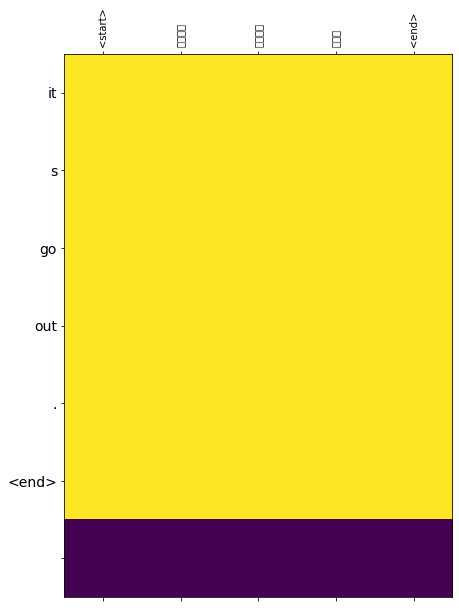

Input: <start> बाहर निकल जाओ <end>
Predicted translation: it s go out . <end> 


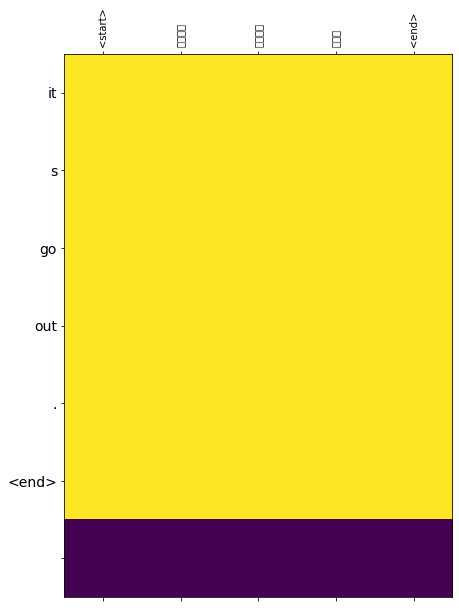

In [92]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

translate(u'बाहर निकल जाओ')
translate(u'बाहर निकल जाओ')



Input: <start> सर्दी आ रही है। <end>
Predicted translation: it s like to go to go to go to go to go to go to go to go to go to go to go to go to 


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2360 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2381 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2342 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2310 missing from current font.
  font.set_text(s

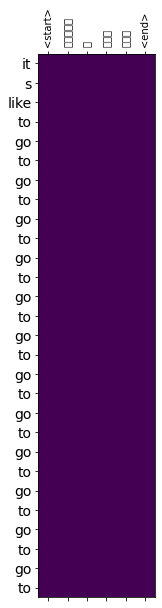

In [94]:
translate(u"सर्दी आ रही है।")

In [105]:
# correct translation
translate(u'मेरा पेट भर गया है।')
translate(u'मैं १९६० में पैदा हुआ था।')
translate(u'अंग्रेज़ी बोलना आसान नहीं है।')
translate(u'सौभाग्य न सब दिन सोता है, देखें आगे क्या होता है।')
translate(u'इसे पढ़ें दोबारा ।')
translate(u'कुछ मछलियाँ उड़ सकतीं हैं।')
translate(u"तुम्हें मन लगाकर पढ़ना होगा।")

Input: <start> मेरा पेट भर गया है। <end>
Predicted translation: i m full . <end> 
Input: <start> मैं १९६० में पैदा हुआ था। <end>
Predicted translation: i was born in . <end> 
Input: <start> अंग्रेज़ी बोलना आसान नहीं है। <end>
Predicted translation: speaking english isn t easy . <end> 
Input: <start> सौभाग्य न सब दिन सोता है , देखें आगे क्या होता है। <end>
Predicted translation: it is true . <end> 
Input: <start> इसे पढ़ें दोबारा । <end>
Predicted translation: i ve made it s go there . <end> 
Input: <start> कुछ मछलियाँ उड़ सकतीं हैं। <end>
Predicted translation: few people live away . <end> 
Input: <start> तुम्हें मन लगाकर पढ़ना होगा। <end>
Predicted translation: i ve read her room . <end> 


Which parts of the sentence are used as a token? Each character, each word, or are some words split up?
Do the same tokens in different language have the same ID?
e.g. Would the same token index map to the German word die and to the English word die?

In [ ]:
Ans: Each Words are used as tokens. No. 

What is the relation between the encoder output and the encoder hidden state which is used to initialize the decoder hidden state (for the architecture used in the tutorial)?


In [ ]:
Ans: encoderoutput = a1 * h1 + a2 * h2 + .... + an * hn
      where a1,a2,..,an are attention weights
            h1,h2,...,hn are encoder hidden states

Is the decoder attending to all previous positions, including the previous decoder predictions?

In [ ]:
Ans: Yes, decoder is attending all the previous positions of the encoder and only the last decoder predictied position.

Does the Encoder output change in different decoding steps?

In [ ]:
No, Encoder output doesn't changes at different decoding steps.

Does the context vector change in different decoding steps?

In [ ]:
Yes.

The decoder uses teacher forcing. Does this mean the time steps can be computed in parallel?

In [ ]:
No. Since we have Recurrrence connection between decoder hidden state.

Why is a mask applied to the loss function?

In [ ]:
Since we have a variable lenghth sequence , we do not calculate loss of the padded values in the sequence.

Bonus1: Can you prevent the attention mechanism from attending to padded positions in the sequence?

Bonus2: The tutorial suggests to restore checkpoints for loading a model. This is inconvenient, because you first need to process the data, build the whole architecture and then initialize it from the checkpoint. It would be much nicer to simply load a model and run translations with it. Can you find a way to achieve this?

In [ ]:
https://www.tensorflow.org/guide/keras/save_and_serialize
model.save
keras.models.load_model('path/to/location')